# Treadmill Data: Nike Vaporfly 2%


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import spm1d
from spm1d import stats

# Read the Excel file into a pandas DataFrame
df = pd.read_excel('2024-02-26-11-11_Adult_Running-Vaporfly.xlsx')

In [2]:
# Identify foot strike (FS) events for both left and right sides
left_fs_indices = []
right_fs_indices = []

# Function to find the first non-zero number and skip subsequent numbers and zeroes
def find_fs_indices(column):
    fs_indices = []
    i = 0
    while i < len(column):
        if column[i] != 0:
            fs_indices.append(i)
            while i < len(column) and column[i] != 0:
                i += 1
        else:
            i += 1
    return fs_indices

# Find FS indices for left foot
left_fs_indices = find_fs_indices(df['LT Max Pressure (N/cm²)'])

# Find FS indices for right foot
right_fs_indices = find_fs_indices(df['RT Max Pressure (N/cm²)'])

# Function to normalize data to 101 data points
def normalize_data(data):
    x = np.linspace(0, 100, len(data))  # Original x values
    x_new = np.linspace(0, 100, 101)    # New x values for normalization
    
    # Perform spline interpolation
    interp_func = interp1d(x, data, kind='cubic')
    
    # Interpolate new y values
    normalized_data = interp_func(x_new)
    
    return normalized_data


# Function to extract normalized stride data
def extract_stride_data(df, indices, side):
    stride_data = []
    for i in range(len(indices) - 1):
        start_index = indices[i]
        end_index = indices[i+1]
        if end_index - start_index > 100:
            stride_pressure = normalize_data(df[side + ' Max Pressure (N/cm²)'].iloc[start_index:end_index])
            stride_force = normalize_data(df[side + ' Force (N)'].iloc[start_index:end_index])
            stride_data.append({'Pressure': stride_pressure, 'Force': stride_force})
    return stride_data

# Extract normalized stride data for left and right sides
left_stride_data = extract_stride_data(df, left_fs_indices, 'LT')
right_stride_data = extract_stride_data(df, right_fs_indices, 'RT')

# Store normalized data in separate DataFrames
L_Pressure_Normalized = pd.DataFrame([stride['Pressure'] for stride in left_stride_data]).transpose()
L_Force_Normalized = pd.DataFrame([stride['Force'] for stride in left_stride_data]).transpose()
R_Pressure_Normalized = pd.DataFrame([stride['Pressure'] for stride in right_stride_data]).transpose()
R_Force_Normalized = pd.DataFrame([stride['Force'] for stride in right_stride_data]).transpose()



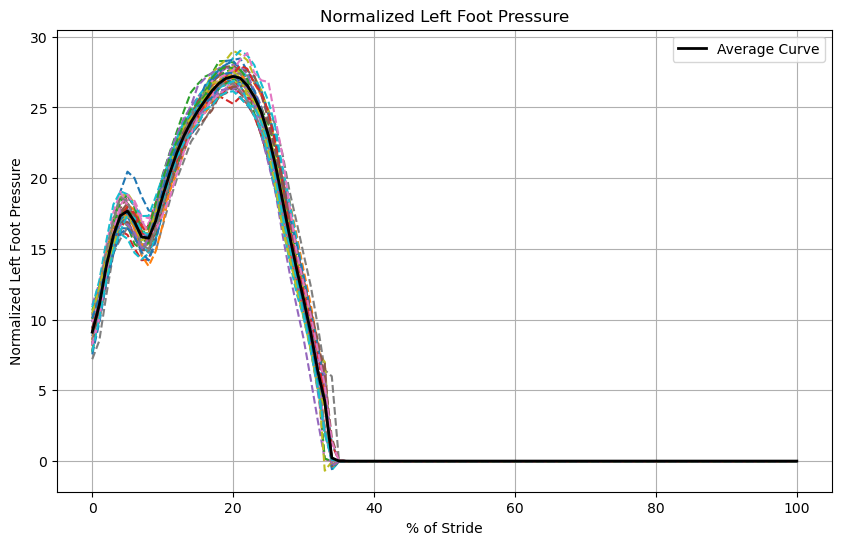

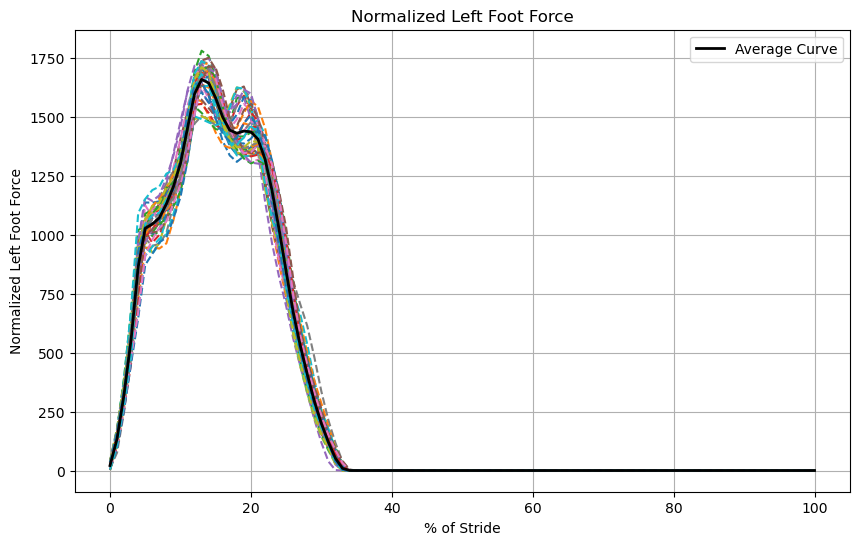

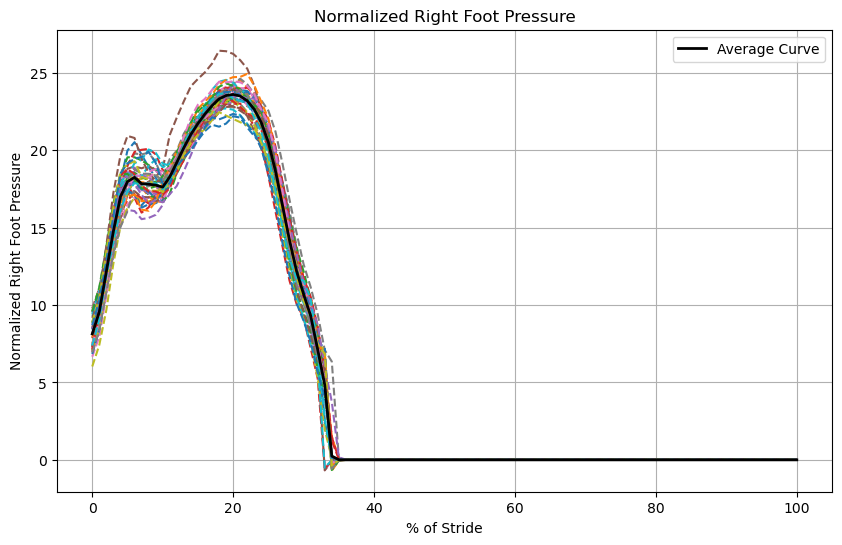

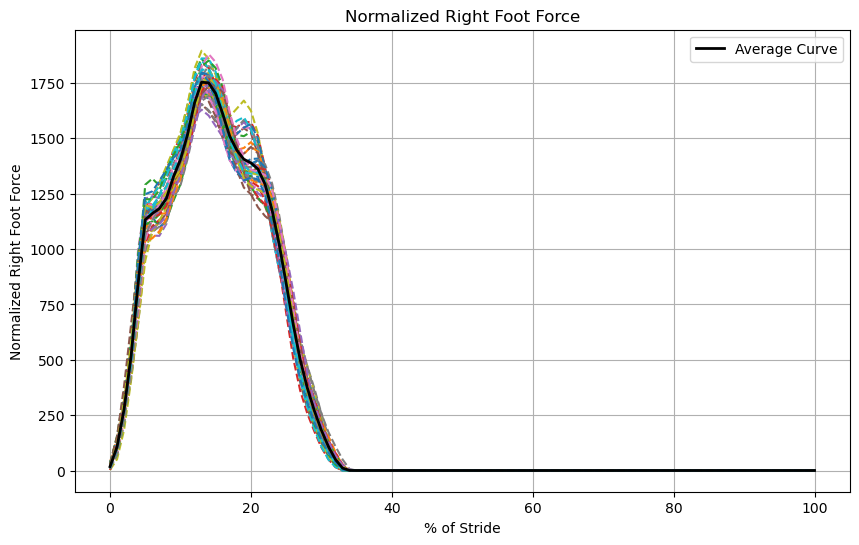

In [4]:
# Functions to plot the curves from the dataframes, with the average curve in black. 
def plot_signals(df, title):
    fig, ax = plt.subplots(figsize=(10, 6))
    for column in df.columns:
        ax.plot(df.index, df[column], label=None, linestyle='--')
    average_curve = df.mean(axis=1)
    ax.plot(df.index, average_curve, color='black', linewidth=2, label='Average Curve')
    ax.set_xlabel('% of Stride')
    ax.set_ylabel(title.replace('_', ' '))
    ax.set_title(title.replace('_', ' '))
    ax.legend()
    ax.grid(True)
    plt.show()

def plot_all_signals(L_Pressure_Normalized, L_Force_Normalized, R_Pressure_Normalized, R_Force_Normalized):
    plot_signals(L_Pressure_Normalized, 'Normalized Left Foot Pressure')
    plot_signals(L_Force_Normalized, 'Normalized Left Foot Force')
    plot_signals(R_Pressure_Normalized, 'Normalized Right Foot Pressure')
    plot_signals(R_Force_Normalized, 'Normalized Right Foot Force')


plot_all_signals(L_Pressure_Normalized, L_Force_Normalized, R_Pressure_Normalized, R_Force_Normalized)

In [5]:
# Function to find the max of the curve, % stide of max, and % stride of foot off
def analyze_curves(average_curve):
    max_value = average_curve.max()
    max_index = average_curve.idxmax()
    foot_off_index = average_curve[average_curve < 1].index[0]
    foot_off_percent = foot_off_index / len(average_curve) * 100
    return pd.Series({'Max Value': max_value, 'Max Value % of Stride': max_index / len(average_curve) * 100,
                      'Foot Off % of Stride': foot_off_percent})

results = {'Left Foot Pressure': L_Pressure_Normalized,
           'Left Foot Force': L_Force_Normalized,
           'Right Foot Pressure': R_Pressure_Normalized,
           'Right Foot Force': R_Force_Normalized}

analysis_data = pd.DataFrame()
for title, data in results.items():
    result = analyze_curves(data.mean(axis=1))
    analysis_data[title] = result

In [6]:
analysis_data

,Left Foot Pressure,Left Foot Force,Right Foot Pressure,Right Foot Force
Max Value,27.189903,1660.131354,23.597934,1753.309494
Max Value % of Stride,19.801980,12.871287,19.801980,12.871287
Foot Off % of Stride,33.663366,33.663366,33.663366,33.663366
